In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout

2024-09-24 11:46:04.859007: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-09-24 11:46:04.859573: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-09-24 11:46:04.861960: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-09-24 11:46:04.868910: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-24 11:46:04.880658: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been 

In [2]:
rndr_df = pd.read_csv('RNDR_historical_data.csv')

In [3]:
# Function to preprocess the data with proper scaling (no data leakage)
def preprocess_data(data, sequence_length=50):
    # Split the data before scaling (train/test split should not be leaked)
    train_size = int(len(data) * 0.8)
    train_data = data[:train_size]
    test_data = data[train_size:]
    
    # Initialize scaler and fit on the training data only
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_train_data = scaler.fit_transform(train_data)

    # Apply the scaler to both training and test data
    scaled_test_data = scaler.transform(test_data)

    X_train, y_train = [], []
    for i in range(sequence_length, len(scaled_train_data)):
        X_train.append(scaled_train_data[i-sequence_length:i])
        y_train.append(scaled_train_data[i])
    
    X_train, y_train = np.array(X_train), np.array(y_train)

    # Prepare test data similarly
    X_test, y_test = [], []
    for i in range(sequence_length, len(scaled_test_data)):
        X_test.append(scaled_test_data[i-sequence_length:i])
        y_test.append(scaled_test_data[i])
    
    X_test, y_test = np.array(X_test), np.array(y_test)

    return X_train, y_train, X_test, y_test, scaler

In [4]:
# Function to create and compile LSTM or GRU models
def create_model(model_type, input_shape):
    model = Sequential()

    if model_type == 'LSTM':
        model.add(LSTM(units=100, return_sequences=True, input_shape=input_shape))
        model.add(Dropout(0.3))
        model.add(LSTM(units=100, return_sequences=False))
    elif model_type == 'GRU':
        model.add(GRU(units=100, return_sequences=True, input_shape=input_shape))
        model.add(Dropout(0.3))
        model.add(GRU(units=100, return_sequences=False))
    
    model.add(Dropout(0.3))
    model.add(Dense(units=1))  # Output layer for price prediction

    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

In [5]:
# Function to train and test the model
def train_and_evaluate_model(data, model_type, sequence_length=50, epochs=10, batch_size=32):
    # Preprocessing the data with proper train/test split and scaling
    X_train, y_train, X_test, y_test, scaler = preprocess_data(data, sequence_length=sequence_length)

    # Create model
    model = create_model(model_type, (X_train.shape[1], X_train.shape[2]))
    
    # Train the model
    model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size)
    
    # Make predictions on the test data
    y_pred = model.predict(X_test)

    # Inverse transform the predicted values
    y_pred_scaled = scaler.inverse_transform(y_pred)
    y_test_scaled = scaler.inverse_transform(y_test.reshape(-1, 1))
    
    # Plot the results
    plt.figure(figsize=(14, 6))
    plt.plot(y_test_scaled, color='blue', label='Real Prices')
    plt.plot(y_pred_scaled, color='red', label=f'Predicted Prices ({model_type})')
    plt.title(f'{model_type} Model Predictions')
    plt.xlabel('Time')
    plt.ylabel('Price')
    plt.legend()
    plt.show()

    return model

In [6]:
# Load your data
data = pd.read_csv('RNDR_historical_data.csv')['price'].values.reshape(-1, 1)

Epoch 1/10


/home/gustavomachado/.local/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.1175
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0159
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0100
Epoch 4/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0112
Epoch 5/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0097
Epoch 6/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0073
Epoch 7/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0070
Epoch 8/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0084
Epoch 9/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0071
Epoch 10/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0069
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


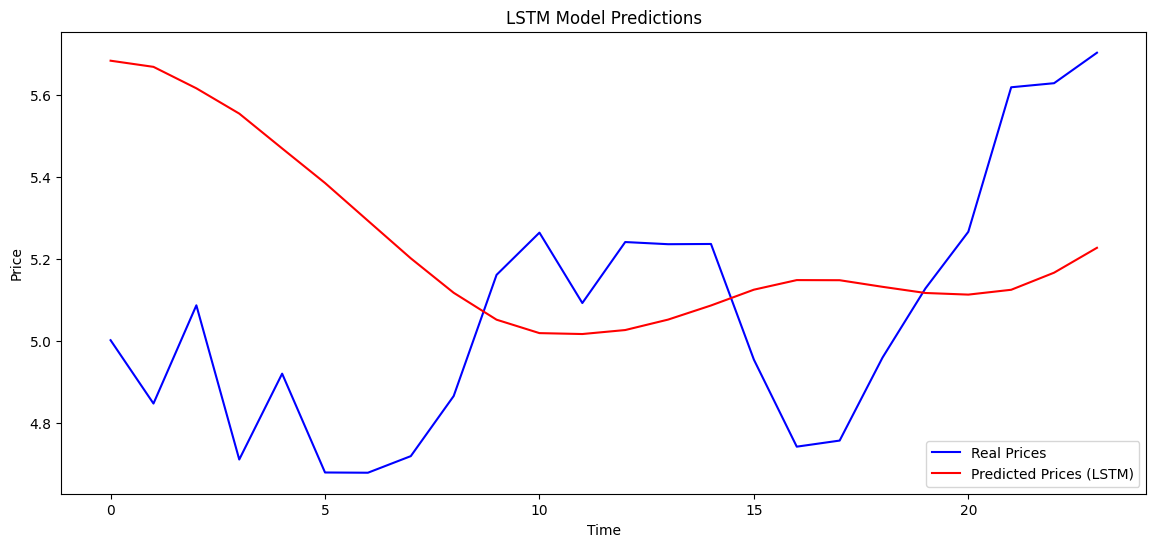

Epoch 1/10


/home/gustavomachado/.local/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.1142
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0175
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0135
Epoch 4/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0074
Epoch 5/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0069
Epoch 6/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0056
Epoch 7/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0051
Epoch 8/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0061
Epoch 9/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0054
Epoch 10/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0047
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


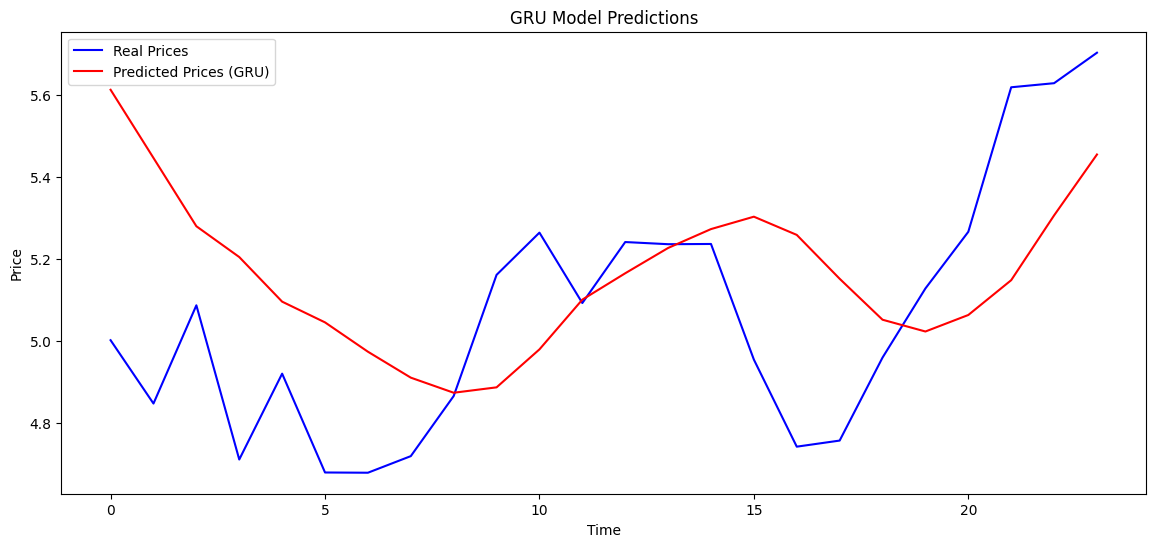

<Sequential name=sequential_1, built=True>

In [7]:
# Train and evaluate both LSTM and GRU models
train_and_evaluate_model(data, 'LSTM', sequence_length=50, epochs=10, batch_size=32)
train_and_evaluate_model(data, 'GRU', sequence_length=50, epochs=10, batch_size=32)